## Нахождение собственных значений и собственных векторов симметричных разреженных матриц большой размерности. Метод Ланцоша
Выполнил **Свистельников Илья**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import random
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import eigsh
from tqdm import tqdm

In [2]:
def generate_sparse_symmetric_matrix(size, density, random_state=None):
    """
    Генерирует разреженную симметричную квадратную матрицу.

    :param size: Размер матрицы (size x size).
    :param density: Плотность матрицы (доля ненулевых элементов, 0 < density <= 1).
    :param random_state: Случайное состояние для воспроизводимости.
    :return: Разреженная симметричная матрица в формате CSR.
    """
    # Генерируем разреженную случайную матрицу
    sparse_matrix = random(size, size, density=density, format='csr', random_state=random_state, data_rvs=np.random.rand)

    # Приводим к симметричной форме: A = (A + A.T) / 2
    symmetric_matrix = (sparse_matrix + sparse_matrix.T) / 2

    # Преобразуем в формат CSR для удобства работы
    symmetric_matrix = csr_matrix(symmetric_matrix)

    return symmetric_matrix

In [3]:
def lanczos_method(A, k, max_iter=100):
    """
    Реализация метода Ланцоша для нахождения k собственных значений и векторов
    симметричной разреженной матрицы A.

    :param A: Симметричная разреженная матрица (размерность N x N)
    :param k: Число собственных значений, которые нужно найти
    :param max_iter: Максимальное число итераций
    :return: Собственные значения и собственные векторы
    """
    n = A.shape[0]
    q = np.random.rand(n)  # Начальный случайный вектор
    q = q / np.linalg.norm(q)  # Нормализация
    Q = np.zeros((n, max_iter))  # Матрица для ортогональных векторов
    Q[:, 0] = q
    T = np.zeros((max_iter, max_iter))  # Тридиагональная матрица

    for j in range(max_iter - 1):
        z = A @ Q[:, j]  # Умножение матрицы на текущий вектор
        if j > 0:
            z -= T[j, j-1] * Q[:, j-1]  # Убираем влияние предыдущего вектора
        T[j, j] = np.dot(Q[:, j], z)  # Вычисляем α_j
        z -= T[j, j] * Q[:, j]  # Ортогонализация
        T[j+1, j] = np.linalg.norm(z)  # Вычисляем β_j
        if T[j+1, j] == 0:
            break
        Q[:, j+1] = z / T[j+1, j]  # Нормализация

    # Собственные значения и векторы тридиагональной матрицы
    eigvals, eigvecs = np.linalg.eigh(T[:j+1, :j+1])
    eigvecs = Q[:, :j+1] @ eigvecs  # Преобразуем в собственные векторы исходной матрицы

    return eigvals[:k], eigvecs[:, :k]

In [4]:
# Пример использования
N = 1000  # Размерность матрицы
density = 0.02   # Плотность (1% ненулевых элементов)
random_state = 42 # Для воспроизводимости

A = generate_sparse_symmetric_matrix(N, density, random_state)
A_1 = A.toarray()
for i in range(N):
  A_1[i, i] = np.random.rand()

eigvals_theor = np.sort(np.real(np.linalg.eigvals(A_1)))

k = 500  # Число собственных значений
c = 5
eigvals, eigvecs = lanczos_method(A_1, k, k*2)

eigvals_for_print = np.zeros(k)

for i in range(k):
  for j in range(N):
    if np.abs(round(eigvals[i], 2) - round(eigvals_theor[j], 2)) < c*1e-2:
      eigvals_for_print[i] = eigvals_theor[j]
      break

E = np.linalg.norm([np.abs(eigvals_for_print[i] - eigvals[i]) for i in range(k)])

print(f"Погрешность вычесления первых k собственных значений матрицы A: {E}")

Погрешность вычесления первых k собственных значений матрицы A: 0.9862174237960717


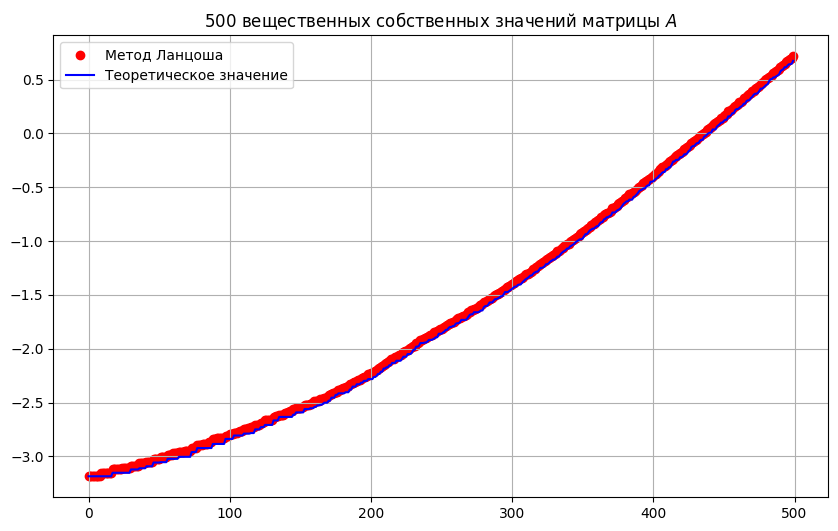

In [5]:
plt.figure(figsize=(10,6))

plt.scatter([i for i in range(k)], eigvals, marker='o', color='red', label='Метод Ланцоша')
plt.plot(eigvals_for_print, color='blue', label='Теоретическое значение')
plt.legend()
plt.grid()
plt.title(f"{k} вещественных собственных значений матрицы $A$")

plt.show()

In [6]:
k_arr = np.array([10, 20, 50, 80, 110, 150, 200, 250, 300, 400, 500])
E_arr = []
for p in tqdm(range(len(k_arr))):
    A = generate_sparse_symmetric_matrix(N, density, random_state)
    A_1 = A.toarray()
    for i in range(N):
      A_1[i, i] = np.random.rand()

    eigvals_theor = np.sort(np.real(np.linalg.eigvals(A_1)))
    c = 5
    eigvals, eigvecs = lanczos_method(A_1, k_arr[p], k_arr[p]*2)

    eigvals_for_print = np.zeros(k_arr[p])

    for i in range(k_arr[p]):
      for j in range(N):
        if np.abs(round(eigvals[i], 2) - round(eigvals_theor[j], 2)) < c*1e-2:
          eigvals_for_print[i] = eigvals_theor[j]
          break

    E = np.linalg.norm([np.abs(eigvals_for_print[i] - eigvals[i]) for i in range(k_arr[p])])
    E_arr.append(E)

E_arr = np.array(E_arr)

100%|██████████| 11/11 [00:15<00:00,  1.37s/it]


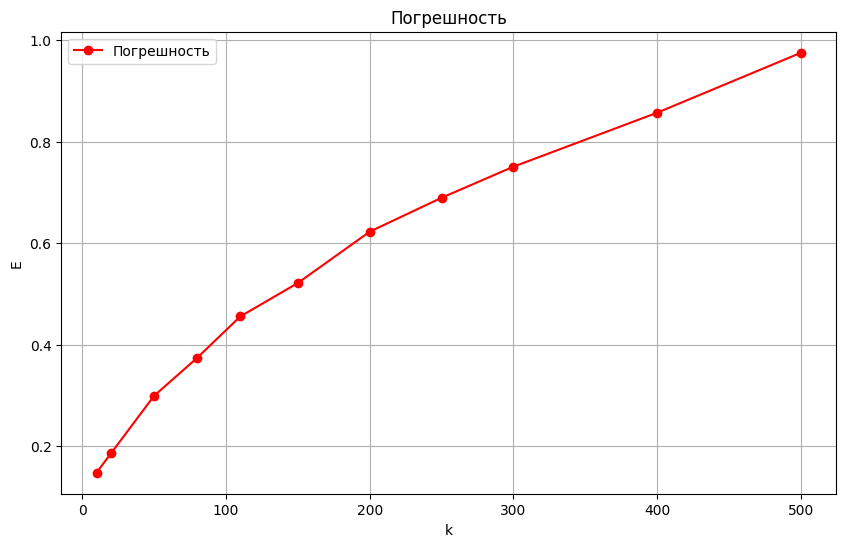

In [7]:
plt.figure(figsize=(10,6))

plt.plot(k_arr, E_arr, marker='o', color='red', label='Погрешность')
plt.legend()
plt.grid()
plt.title("Погрешность")
plt.xlabel("k")
plt.ylabel("E")

plt.show()

In [8]:
N1 = 10
density1 = 0.1
random_state1 = 42
A1 = generate_sparse_symmetric_matrix(N1, density1, random_state1)
print(A1.toarray())

[[0.16475062 0.42825666 0.         0.         0.         0.
  0.         0.15011346 0.40790084 0.        ]
 [0.42825666 0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.40132982 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.01839312
  0.         0.         0.40922744 0.22785863]
 [0.         0.         0.         0.         0.23031107 0.37587567
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.01839312 0.37587567 0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.15011346 0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.40790084 0.         0.         0.40922744 0.         0.
  0.         0.         0.         0.        ]
 [0.         0.      

Размер матрицы (N): 100%|██████████| 10/10 [01:05<00:00,  6.55s/it]


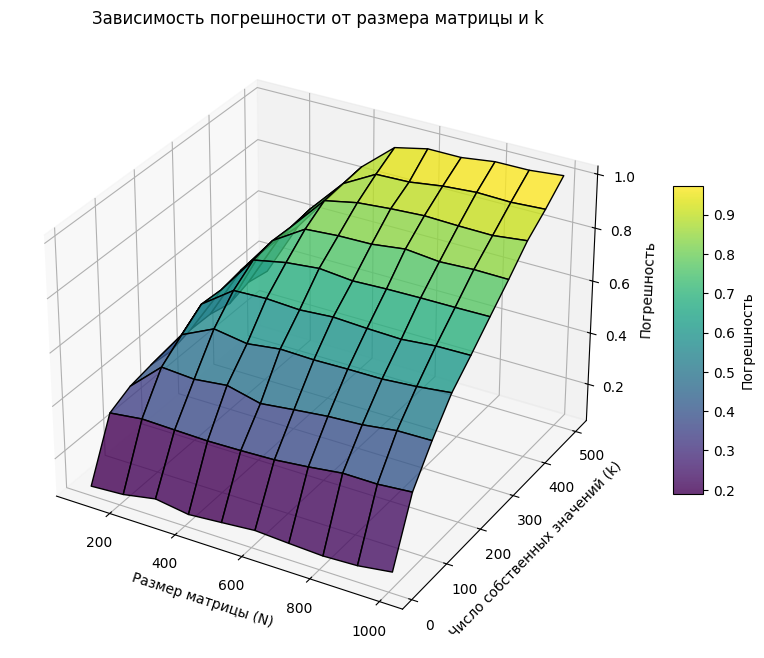

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import random
from scipy.sparse import csr_matrix
from tqdm import tqdm

def generate_sparse_symmetric_matrix(size, density, random_state=None):
    """
    Генерация разреженной симметричной матрицы заданной плотности.
    """
    sparse_matrix = random(size, size, density=density, format='csr', random_state=random_state, data_rvs=np.random.rand)
    symmetric_matrix = (sparse_matrix + sparse_matrix.T) / 2
    return csr_matrix(symmetric_matrix)

def compute_error(A, eigvals_theor, k):
    """
    Вычисление ошибки на основе первых k собственных значений.
    """
    k = min(k, A.shape[0])  # Убедимся, что k не превышает размер матрицы
    eigvals = np.linalg.eigh(A)[0][:k]  # Первые k собственных значений
    eigvals_for_print = np.zeros(k)

    for i in range(k):
        for j in range(len(eigvals_theor)):
            if np.abs(round(eigvals[i], 2) - round(eigvals_theor[j], 2)) < 5e-2:
                eigvals_for_print[i] = eigvals_theor[j]
                break

    error = np.linalg.norm([np.abs(eigvals_for_print[i] - eigvals[i]) for i in range(k)])
    return error

# Диапазоны для N и k
N_range = np.linspace(100, 1000, 10, dtype=int)  # Размер матрицы от 100 до 1000
k_range = np.linspace(10, 500, 10, dtype=int)    # Число собственных значений от 10 до 500

# Плотность матрицы и рандомное состояние
density = 0.02
random_state = 42

# Подготовка для хранения ошибок
errors = np.zeros((len(N_range), len(k_range)))

# Вычисление ошибок
for i, N in enumerate(tqdm(N_range, desc="Размер матрицы (N)")):
    for j, k in enumerate(k_range):
        A = generate_sparse_symmetric_matrix(N, density, random_state).toarray()
        for idx in range(N):
            A[idx, idx] = np.random.rand()

        eigvals_theor = np.sort(np.real(np.linalg.eigvals(A)))
        errors[i, j] = compute_error(A, eigvals_theor, k)

# Построение 3D-графика
N_grid, k_grid = np.meshgrid(N_range, k_range, indexing="ij")
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(N_grid, k_grid, errors, cmap='viridis', edgecolor='k', alpha=0.8)
ax.set_title("Зависимость погрешности от размера матрицы и k")
ax.set_xlabel("Размер матрицы (N)")
ax.set_ylabel("Число собственных значений (k)")
ax.set_zlabel("Погрешность")
fig.colorbar(surf, shrink=0.5, aspect=10, label="Погрешность")
plt.show()